<a href="https://colab.research.google.com/github/KadjelRamkisoen/BertIR/blob/main_kate/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os, sys 
nb_path = '/content/notebooks'
# os.symlink('/content/gdrive/My Drive/Colab Notebooks', nb_path)
sys.path.append(nb_path)

In [4]:
!nvidia-smi 

Thu Dec  2 12:03:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
IR_Path = '/content/drive/MyDrive/Information Retrieval/Assignment 2/'

In [6]:
dev_data = 'dev_data.csv'
all_docs = 'all_docs.csv'
dev_queries = 'dev_queries.csv'
test_data = 'test_data.csv'
training_data = 'training_data.csv'
lucene_data = 'raw_dev_Lucene_retrievals.csv'

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv(IR_Path + dev_data,memory_map=True)
# df = pd.read_csv(IR_Path + all_docs)
# df = pd.read_csv(IR_Path + dev_queries)
# df = pd.read_csv(IR_Path + test_data)
# df = pd.read_csv(IR_Path + training_data)
# df = pd.read_csv(IR_Path + lucene_data)

In [9]:
df.head()

,Query_number,doc_number,Query,doc_text,label
0,1089071,432658,va death benefits contact number,Veteran Benefits in Nebraska Ads You May Be In...,1
1,1089071,417115,va death benefits contact number,Home › Benefit Library › State / Territory Ben...,1
2,1089071,429474,va death benefits contact number,"VA Burial Benefits Burial Allowances Burial, H...",1
3,1089071,122086,va death benefits contact number,Home › Benefit Library › Federal Benefits › Bu...,1
4,1089071,60461,va death benefits contact number,Call Today1-844-VET-LAWS (838-5297)REFER A FRI...,1


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19992 entries, 0 to 19991
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Query_number  19992 non-null  int64 
 1   doc_number    19992 non-null  int64 
 2   Query         19992 non-null  object
 3   doc_text      19992 non-null  object
 4   label         19992 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 781.1+ KB


In [20]:
!pip install sentence-transformers 

     |████████████████████████████████| 78 kB 3.5 MB/s 
     |████████████████████████████████| 3.1 MB 11.6 MB/s 
     |████████████████████████████████| 3.3 MB 35.3 MB/s 
     |████████████████████████████████| 1.2 MB 41.4 MB/s 
     |████████████████████████████████| 61 kB 492 kB/s 
     |████████████████████████████████| 596 kB 35.8 MB/s 
     |████████████████████████████████| 895 kB 36.4 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=460db8a034fc9529ace2c17c6135a875652272ac4030b42f7f73efef4a060aac
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [21]:
!pip install faiss-gpu

     |████████████████████████████████| 90.1 MB 21 kB/s 


In [13]:
import time

In [14]:
data = df

In [15]:
df.shape

(19992, 5)

In [16]:
df.dropna(inplace=True)
df.drop_duplicates(subset=['doc_text'],inplace=True)

In [17]:
df.shape

(18260, 5)

In [22]:
# import faiss

In [23]:
## Load our cross-encoder. Use fast tokenizer to speed up the tokenization
from sentence_transformers import CrossEncoder
cross_model = CrossEncoder('cross-encoder/ms-marco-TinyBERT-L-6', max_length=512)

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/541 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [24]:
def cross_score(model_inputs):
    scores = cross_model.predict(model_inputs, show_progress_bar=True)
    return scores

In [25]:
# model_inputs = [[query,item['doc_text']] for item in results]
model_inputs = df[["Query", "doc_text"]].values.tolist()

In [26]:
df.shape

(18260, 5)

In [27]:
scores = cross_score(model_inputs)

Batches:   0%|          | 0/571 [00:00<?, ?it/s]

In [28]:
scores.shape

(18260,)

In [29]:
df["score"] = scores 

In [30]:
df.head(5)

,Query_number,doc_number,Query,doc_text,label,score
0,1089071,432658,va death benefits contact number,Veteran Benefits in Nebraska Ads You May Be In...,1,0.000454
1,1089071,417115,va death benefits contact number,Home › Benefit Library › State / Territory Ben...,1,0.000217
2,1089071,429474,va death benefits contact number,"VA Burial Benefits Burial Allowances Burial, H...",1,0.004744
3,1089071,122086,va death benefits contact number,Home › Benefit Library › Federal Benefits › Bu...,1,0.019925
4,1089071,60461,va death benefits contact number,Call Today1-844-VET-LAWS (838-5297)REFER A FRI...,1,0.491717


In [63]:
df[df.Query_number == 1089085]

,Query_number,doc_number,Query,doc_text,label,score,score_flag
25,1089085,408240,usf admissions office phone number,Visit Admissions Office Usf on the Given Addre...,1,0.986068,1
26,1089085,430821,usf admissions office phone number,|Back | Nursing Program Listing | Catalog Tabl...,1,0.008219,0
27,1089085,316625,usf admissions office phone number,Your Future Starts Here Why Choose USF? Top-ra...,1,0.000862,0
28,1089085,131285,usf admissions office phone number,Admissions Freshman Freshman Admissions Majors...,1,0.000476,0
29,1089085,501118,usf admissions office phone number,Admissions Test Information (Also refer to the...,1,0.000667,0
30,1089085,13154,usf admissions office phone number,Costs The cost of attendance for International...,1,0.000254,0
31,1089085,123721,usf admissions office phone number,Scholarship Award/Benefits GPA & Test Scores I...,1,0.000166,0
32,1089085,310143,usf admissions office phone number,Proof of Enrollment The National Student Clear...,1,0.000679,0
33,1089085,31044,usf admissions office phone number,Colleges That Superscore ACT: Complete List Po...,1,0.000172,0
34,1089085,387331,usf admissions office phone number,San Francisco Advantages Business & Technology...,1,0.000165,0


In [32]:
df.score.mean()

0.08778191357851028

In [33]:
df['score_flag'] = np.where(df['score'] >= 0.1, 1, 0)

In [34]:
df.score_flag.mean()

0.15032858707557503

In [35]:
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_fscore_support, confusion_matrix, plot_confusion_matrix

In [66]:
precision_recall_fscore_support(df.label, df.score_flag)

(array([0.54874406, 0.66685552]),
 array([0.87298844, 0.2615265 ]),
 array([0.6738922 , 0.37570824]),
 array([9259, 9001]))

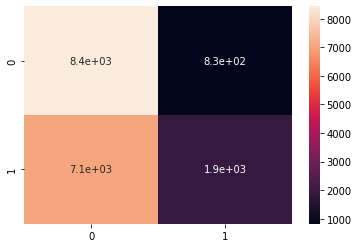

In [36]:
sns.heatmap(confusion_matrix(df.label, df.score_flag), annot=True)

In [42]:
print("ROC  AUC: ", roc_auc_score(df.label, df.score).round(2))
print("F1-score: ", f1_score(df.label, df.score_flag).round(2))

ROC  AUC:  0.6
F1-score:  0.33


In [41]:
df.to_csv(IR_Path+"baseline.csv")

# Parameters tuning

In [98]:
import logging
import tensorflow_hub as tf_hub
from datetime import datetime
from sentence_transformers import LoggingHandler, util
from sklearn.model_selection import train_test_split
from sentence_transformers.cross_encoder.evaluation import CECorrelationEvaluator
from sentence_transformers import InputExample
from torch.utils.data import DataLoader
import math

In [74]:
#### Just some code to print debug information to stdout
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])
logger = logging.getLogger(__name__)
#### /print debug information to stdout


In [75]:
#Define our Cross-Encoder
train_batch_size = 16
num_epochs = 4
model_save_path = IR_Path + 'base_benchmark-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [76]:
model_save_path


'/content/drive/MyDrive/Information Retrieval/Assignment 2/base_benchmark-2021-12-02_12-44-39'

In [59]:
df_training = pd.read_csv(IR_Path + training_data)

In [60]:
df_training.shape

(140000, 6)

In [61]:
df_training.head()

,Query_number,Query,doc_text,doc_number,index,label
0,166043,does estrogen make me start my period,Estrogen patch types Common Questions and Answ...,31135,23076,1
1,284072,how many gallons is liters,Answers.com ® Wiki Answers ® Categories Cars &...,317907,27572,1
2,277737,how many calories in skyy vodka,Vodka Tonic (7)Recipe by newspapergal“I couldn...,188074,79593,1
3,1059801,whos the third president of usa,"From Wikipedia, the free encyclopedia (Redirec...",313468,74658,1
4,237561,how is the element magnesium used,1. Biogenic elements. Qualitative reaction for...,33071,28572,1


In [107]:
X_train, X_test, y_train, y_test = train_test_split(df_training[['Query', 'doc_text']][:20000], df_training['label'][:20000], test_size=0.25, random_state=42)

In [108]:
df_training[['Query', 'doc_text']].shape

(140000, 2)

In [109]:
train_text = X_train[['Query', 'doc_text']].values.tolist()
train_labels = y_train.tolist()

val_text = df[['Query', 'doc_text']].values.tolist()
val_labels = df['label'].tolist()

test_text = X_test[['Query', 'doc_text']].values.tolist()
test_labels = y_test.tolist()

In [110]:
### https://colab.research.google.com/github/dipanjanS/nlp_workshop_odsc19/blob/master/Module05%20-%20NLP%20Applications/Project07E%20-%20Text%20Classification%20with%20BERT%20Deep%20Transfer%20Learning.ipynb#scrollTo=fe--ekRZZ6Jy

def create_tokenizer_from_hub_module(bert_path):
    """Get the vocab file and casing info from the Hub module."""
    bert_module =  tf_hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

In [111]:
def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(InputExample(texts=[text[0], text[1]], label=label))
        InputExamples.append(InputExample(texts=[text[0], text[1]], label=label))
    return InputExamples

In [112]:
train_samples = convert_text_to_examples(train_text, train_labels)
test_samples = convert_text_to_examples(test_text, test_labels)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [113]:
# We wrap train_samples (which is a List[InputExample]) into a pytorch DataLoader
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)

# We add an evaluator, which evaluates the performance during training
evaluator = CECorrelationEvaluator.from_input_examples(test_samples, name='test_bert')


In [114]:
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
logger.info("Warmup-steps: {}".format(warmup_steps))


2021-12-02 13:03:06 - Warmup-steps: 750


In [115]:
cross_model.fit(train_dataloader=train_dataloader,
          evaluator=evaluator,
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          output_path=model_save_path)

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1875 [00:00<?, ?it/s]

2021-12-02 13:53:43 - CECorrelationEvaluator: Evaluating the model on test_bert dataset after epoch 0:
2021-12-02 13:59:29 - Correlation:	Pearson: 0.3740	Spearman: 0.3758
2021-12-02 13:59:29 - Save model to /content/drive/MyDrive/Information Retrieval/Assignment 2/base_benchmark-2021-12-02_12-44-39


Iteration:   0%|          | 0/1875 [00:00<?, ?it/s]

2021-12-02 14:50:17 - CECorrelationEvaluator: Evaluating the model on test_bert dataset after epoch 1:
2021-12-02 14:56:06 - Correlation:	Pearson: 0.3545	Spearman: 0.3790
2021-12-02 14:56:06 - Save model to /content/drive/MyDrive/Information Retrieval/Assignment 2/base_benchmark-2021-12-02_12-44-39


Iteration:   0%|          | 0/1875 [00:00<?, ?it/s]

2021-12-02 15:47:04 - CECorrelationEvaluator: Evaluating the model on test_bert dataset after epoch 2:
2021-12-02 15:52:54 - Correlation:	Pearson: 0.3239	Spearman: 0.3711


Iteration:   0%|          | 0/1875 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [1]:
##### Load model and eval on test set
trained_model = CrossEncoder(model_save_path)

evaluator = CECorrelationEvaluator.from_input_examples(test_samples, name='sts-test')


NameError: ignored

In [ ]:
evaluator(trained_model)

In [81]:
# BERT_PATH = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
# # Instantiate tokenizer
# tokenizer = create_tokenizer_from_hub_module(BERT_PATH)
# # train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print('Classification Report:')
print(classification_report(y_true=test_labels, y_pred=test_pred_labels))